_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 10, 10, 64)        36928     
__________

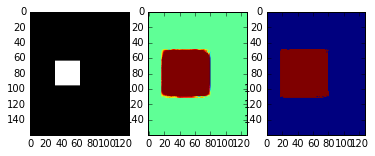

In [10]:
%matplotlib inline

import keras
from keras import backend as K
from keras.layers import Input, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Lambda

import numpy as np
import cv2
import sys
import os
import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "" # Set CPU mode
n_classes= 2
image_size= 32

#Create black and white dummy dataset, classification accuracy should be 100%
def create_data():
    n_samples= 40
    neg_samples= np.zeros((n_samples,image_size,image_size,3),np.uint8)
    pos_samples= 255*np.ones((n_samples,image_size,image_size,3),np.uint8)
    X= np.concatenate((neg_samples,pos_samples),axis=0)
    neg_samples_labels= np.zeros((n_samples),np.uint8)
    pos_samples_labels= np.ones((n_samples),np.uint8)
    y= np.concatenate((neg_samples_labels,pos_samples_labels),axis=0)
    
    #shuffle
    indx= np.random.permutation(X.shape[0])
    X= X[indx]
    y= y[indx]
    
    #convert to categorical
    y = keras.utils.to_categorical(y, n_classes)
    
    #Scale data
    mean = np.mean(X)
    std = np.std(X)
    X = (X - mean) / std
    
    return X,y

#Let's create cifar-like model
#https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
def get_cifar_model():    
    inputs = Input((image_size,image_size,3))
    
    conv1= Conv2D(32, (3, 3), activation='relu')(inputs)
    conv2= Conv2D(32, (3, 3), activation='relu')(conv1)
    pool1= MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1= Dropout(0.25)(pool1)
    
    conv3= Conv2D(64, (3, 3), activation='relu')(drop1)
    conv4= Conv2D(64, (3, 3), activation='relu')(conv3)
    pool2= MaxPooling2D(pool_size=(2, 2))(conv4)
    drop2= Dropout(0.25)(pool2)
    
    conv5= Conv2D(128, (5, 5), activation='relu')(drop2)
    drop3= Dropout(0.25)(conv5)
    conv6= Conv2D(n_classes, (1, 1), name='conv6')(drop3)
    flat1= Flatten()(conv6)
    act1= Activation('softmax')(flat1)
    
    model = Model(inputs=[inputs], outputs=[act1])
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    print model.summary()
    #sys.exit()
    
    return model

def train_cifar():
    model= get_cifar_model()
    
    X,y= create_data()
    model.fit(X,y,batch_size=10,epochs=20)
    
    model.save_weights('cifar_model_weights.h5')

#Let's do sliding window classification with original cifar network
def test_cifar():
    img= np.zeros((5*image_size,4*image_size,3),np.uint8)
    img[2*image_size:3*image_size,image_size:2*image_size]= 255
    img= cv2.copyMakeBorder(img,image_size/2,image_size/2,image_size/2,image_size/2,cv2.BORDER_REPLICATE)
    print 'img.shape', img.shape
    
    model= get_cifar_model()
    model.load_weights('cifar_model_weights.h5')
    
    pred_map= np.zeros((img.shape[0], img.shape[1], n_classes),np.float32)
    img_batch= img[None, ...]
    for y in range(img.shape[0]-image_size):
        for x in range(img.shape[1]-image_size):
            tile= img_batch[:,y:y+image_size,x:x+image_size,:]
            pred_map[y+image_size/2,x+image_size/2]= model.predict(tile)
    
    print 'pred_map.shape', pred_map.shape
    
    #Crop central part of padded image
    img= img[image_size/2:-image_size/2,image_size/2:-image_size/2]
    pred_map= pred_map[image_size/2:-image_size/2,image_size/2:-image_size/2]
    print 'img.shape', img.shape
    print 'pred_map.shape', pred_map.shape
    
    #plot original image, positive predition probs and thresholded binary
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2)
    pos= pred_map[:,:,1]
    plt.imshow(pos)
    plt.subplot(1,3,3)
    pos[pos > 0.5]= 255
    pos[pos <= 0.5]= 0
    plt.imshow(pos)
    plt.show()
    
train_cifar()
test_cifar()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 10, 10, 64)        36928     
__________

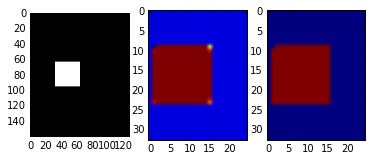

In [13]:
%matplotlib inline

import keras
from keras import backend as K
from keras.layers import Input, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Lambda

import numpy as np
import cv2
import sys
import os
import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "" # Set CPU mode
n_classes= 2
image_size= 32

#Create black and white dummy dataset, classification accuracy should be 100%
def create_data():
    n_samples= 40
    neg_samples= np.zeros((n_samples,image_size,image_size,3),np.uint8)
    pos_samples= 255*np.ones((n_samples,image_size,image_size,3),np.uint8)
    X= np.concatenate((neg_samples,pos_samples),axis=0)
    neg_samples_labels= np.zeros((n_samples),np.uint8)
    pos_samples_labels= np.ones((n_samples),np.uint8)
    y= np.concatenate((neg_samples_labels,pos_samples_labels),axis=0)
    
    #shuffle
    indx= np.random.permutation(X.shape[0])
    X= X[indx]
    y= y[indx]
    
    #convert to categorical
    y = keras.utils.to_categorical(y, n_classes)
    
    #Scale data
    mean = np.mean(X)
    std = np.std(X)
    X = (X - mean) / std
    
    return X,y

def fc_reshape(x):
    if(x.shape[1]==1):
        x_new= K.reshape(x,(-1,n_classes))
    else:
        x_new= x
    
    return x_new

def fc_reshape_output_shape(input_shape):
    if(input_shape[1]==1):
        output_shape= (None,n_classes)
    else:
        output_shape= input_shape
    
    return output_shape
    
#Fully convolutional version of cifar-like network that can have arbitary size input
def get_fc_cifar_model(h,w):
    inputs = Input((h, w, 3))
    
    conv1= Conv2D(32, (3, 3), activation='relu')(inputs)
    conv2= Conv2D(32, (3, 3), activation='relu')(conv1)
    pool1= MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1= Dropout(0.25)(pool1)
    
    conv3= Conv2D(64, (3, 3), activation='relu')(drop1)
    conv4= Conv2D(64, (3, 3), activation='relu')(conv3)
    pool2= MaxPooling2D(pool_size=(2, 2))(conv4)
    drop2= Dropout(0.25)(pool2)
    
    conv5= Conv2D(128, (5, 5), activation='relu')(drop2)
    drop3= Dropout(0.25)(conv5)
    conv6= Conv2D(n_classes, (1, 1), name='conv6')(drop3)
    flat1= Lambda(fc_reshape, output_shape=fc_reshape_output_shape)(conv6)
    act1= Activation('softmax')(flat1)
    
    model = Model(inputs=[inputs], outputs=[act1])
    model.compile(loss='categorical_crossentropy',
            optimizer= keras.optimizers.Adadelta(),
            metrics=['accuracy'])
            
    print (model.summary())
    #sys.exit(0) #
    
    return model

def train_fc_cifar():
    model= get_fc_cifar_model(image_size,image_size)
    
    X,y= create_data()
    model.fit(X,y,batch_size=10,epochs=20)
    
    model.save_weights('cifar_fc_model_weights.h5')
    
#Let's create image bigger than image_sizeximage_size and test FC cifar network    
def test_fc_cifar():
    img= np.zeros((5*image_size,4*image_size,3),np.uint8)
    img[2*image_size:3*image_size,image_size:2*image_size]= 255
    print 'img.shape', img.shape
    
    model= get_fc_cifar_model(img.shape[0],img.shape[1])
    model.load_weights('cifar_fc_model_weights.h5')
    
    pred_map= model.predict(img[None,...])
    print 'pred_map.shape', pred_map.shape
    print 'np.min(pred_map)', np.min(pred_map)
    print 'np.max(pred_map)', np.max(pred_map)
    
    #Plot original image, positive predition probs and thresholded binary
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2)
    pos= pred_map[0,:,:,1]
    plt.imshow(pos)
    plt.subplot(1,3,3)
    pos[pos > 0.5]= 255
    pos[pos <= 0.5]= 0
    plt.imshow(pos)
    plt.show()

train_fc_cifar()
test_fc_cifar()